In [88]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import models

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from torchvision.transforms import Resize

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [89]:
def load_img(path):
    '''Loading images from directory
    and changing color space from cv2 standard BGR to RGB
    for better visualization'''
    image = cv2.imread(path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb

In [90]:
import os

# Replace with the actual path to the folders in your Google Drive
good_dir = "/content/drive/My Drive/GoodImages/"
good_path = os.listdir(good_dir)


In [91]:
len(good_path)

120

In [92]:
bad_dir = "/content/drive/My Drive/BadImages/"
bad_path = os.listdir(bad_dir)

In [93]:
len(bad_path)

88

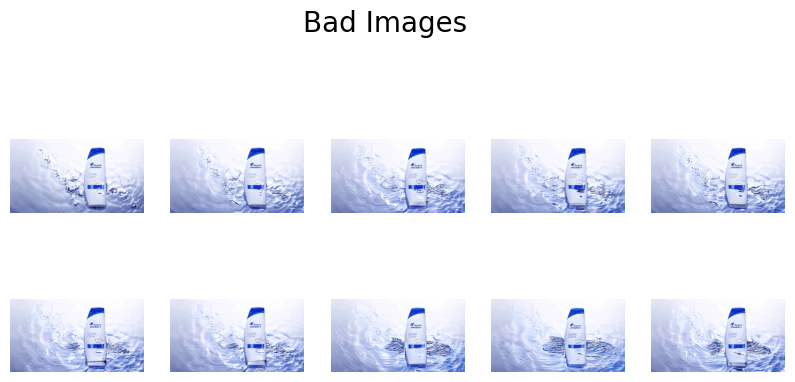

In [94]:
fig = plt.figure(figsize=(10, 10))

for i in range(0,10):
    plt.subplot(5, 5, i+1)
    plt.imshow(load_img(bad_dir + bad_path[i]))
    plt.suptitle("Bad Images", fontsize=20)
    plt.axis('off')

In [95]:
goodimages_df = pd.DataFrame({'image_path': good_dir + good_path[i], 'label': 1} for i in range(0, 120))
badimages_df = pd.DataFrame({'image_path': bad_dir + bad_path[i], 'label': 0} for i in range(0, 88))

In [96]:
df = pd.concat([goodimages_df, badimages_df], ignore_index=True)
df.head()


,image_path,label
0,/content/drive/My Drive/GoodImages/frame_shamp...,1
1,/content/drive/My Drive/GoodImages/frame_dontb...,1
2,/content/drive/My Drive/GoodImages/frame_Shamp...,1
3,/content/drive/My Drive/GoodImages/frame_splas...,1
4,/content/drive/My Drive/GoodImages/frame_splas...,1


In [97]:
df.tail()

,image_path,label
203,/content/drive/My Drive/BadImages/frame_sunscr...,0
204,/content/drive/My Drive/BadImages/frame_smilin...,0
205,/content/drive/My Drive/BadImages/frame_bottle...,0
206,/content/drive/My Drive/BadImages/frame_output...,0
207,/content/drive/My Drive/BadImages/frame_output...,0


In [98]:
df = shuffle(df)
df = df.reset_index(drop=True)
df.head(10)

,image_path,label
0,/content/drive/My Drive/BadImages/frame_sunscr...,0
1,/content/drive/My Drive/GoodImages/frame_cream...,1
2,/content/drive/My Drive/GoodImages/frame_shamp...,1
3,/content/drive/My Drive/GoodImages/frame_Shamp...,1
4,/content/drive/My Drive/BadImages/frame_sunscr...,0
5,/content/drive/My Drive/GoodImages/frame_mung ...,1
6,/content/drive/My Drive/BadImages/frame_shampo...,0
7,/content/drive/My Drive/GoodImages/frame_dontb...,1
8,/content/drive/My Drive/GoodImages/frame_splas...,1
9,/content/drive/My Drive/GoodImages/frame_bottl...,1


In [99]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [100]:
train_label = train_df['label']
train_features = train_df['image_path']

val_label = val_df['label']
val_features = val_df['image_path']

In [101]:
class ImageDataset(Dataset):
    def __init__(self, image_labels, image_dir, transform=None, target_transform=None):
        self.image_labels = image_labels
        self.image_dir = image_dir
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.image_labels)


    def __getitem__(self, index):
        image_path = self.image_dir.iloc[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.image_labels.iloc[index]
        if self.transform:
        # Convert the image to a PyTorch tensor first
          image = ToTensor()(image)
          image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label=label)
        return image, label

In [102]:
transform = Resize((224, 224))
train_dataset = ImageDataset(train_label,
                             train_features,transform = transform)

In [103]:
train_dataset

In [104]:
val_dataset = ImageDataset(val_label,
                           val_features,transform = transform)

In [105]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [106]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_p = models.resnet50(pretrained=True)
model_p.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=512, bias=True),
                     nn.ReLU(inplace=True),
                     nn.Linear(in_features=512, out_features=1, bias=True))
for param in model_p.parameters():
    param.requires_grad = True
model_p.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [107]:
criterion_p = torch.nn.BCELoss()
optimizer_p = torch.optim.Adam(model_p.parameters(), lr=0.00001, weight_decay=1e-5)
scheduler_p = torch.optim.lr_scheduler.ExponentialLR(optimizer_p, gamma=0.9)

In [108]:
def training_loop(model, training_loader, validation_loader, criterion, optimizer, scheduler, epochs=10):
    '''Training loop for train and eval modes'''
    for epoch in range(1, epochs+1):
        model.train()
        train_accuracy = 0
        train_loss = 0
        for image, target in training_loader:
            image = image.to(device)
            target = target.to(device)
            target = target.unsqueeze(1)
            optimizer.zero_grad()
            outputs = torch.sigmoid(model(image))
            loss = criterion(outputs.float(), target.float())

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_accuracy += ((outputs > 0.5) == target).float().mean().item()

        with torch.no_grad():
            model.eval()
            valid_loss = 0
            val_accuracy = 0
            for val_image, val_target in validation_loader:
                val_image = val_image.to(device)
                val_target = val_target.to(device)
                val_target = val_target.unsqueeze(1)
                val_outputs = torch.sigmoid(model(val_image))
                val_loss = criterion(val_outputs.float(), val_target.float())

                valid_loss += val_loss.item()
                val_accuracy += ((val_outputs > 0.5) == val_target).float().mean().item()

        print(f'Epoch: {epoch} Train loss: {train_loss/len(training_loader)} Train accuracy: {train_accuracy /len(training_loader)} Val loss: {valid_loss/len(validation_loader)} Val accuracy: {val_accuracy/len(validation_loader)}')
        scheduler.step()

In [109]:
training_loop(model_p,
              train_loader,
              val_loader,
              criterion_p,
              optimizer_p,
              scheduler_p,
              epochs=10)

Epoch: 1 Train loss: 0.6673018336296082 Train accuracy: 0.6463815768559774 Val loss: 0.6696410775184631 Val accuracy: 0.738095223903656
Epoch: 2 Train loss: 0.6038095951080322 Train accuracy: 0.8467653592427572 Val loss: 0.6418299078941345 Val accuracy: 0.738095223903656
Epoch: 3 Train loss: 0.5595855514208475 Train accuracy: 0.8711622754732767 Val loss: 0.6137904524803162 Val accuracy: 0.738095223903656
Epoch: 4 Train loss: 0.5209997196992239 Train accuracy: 0.890350878238678 Val loss: 0.5859954357147217 Val accuracy: 0.8095238208770752
Epoch: 5 Train loss: 0.48896660407384235 Train accuracy: 0.8991228143374125 Val loss: 0.5599384903907776 Val accuracy: 0.8333333730697632
Epoch: 6 Train loss: 0.47953299681345624 Train accuracy: 0.8706140319506327 Val loss: 0.5357342958450317 Val accuracy: 0.8333333730697632
Epoch: 7 Train loss: 0.44962574044863385 Train accuracy: 0.9040570259094238 Val loss: 0.514921247959137 Val accuracy: 0.8333333730697632
Epoch: 8 Train loss: 0.43017924825350445 Tr

In [110]:
model_p

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [111]:

# Replace with the actual path to the folders in your Google Drive
test_dir = "/content/drive/My Drive/GoodVideos/"
test_path = os.listdir(test_dir)

In [112]:
import cv2
import torch
from torchvision.transforms import ToTensor, Resize

def process_video(video_name, model, device, threshold=0.7):
    # Open the video
    video = cv2.VideoCapture(video_name)

    # Get the video properties
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video.get(cv2.CAP_PROP_FPS)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Define the preprocessor
    transform = Resize((224, 224))

    # Set the model to evaluation mode
    model.eval()

    # Loop through the frames
    for frame_idx in range(total_frames):
        # Read the next frame
        ret, frame = video.read()
        if not ret:
            break

        # Preprocess the frame
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = ToTensor()(frame)
        frame = transform(frame)

        # Create a data batch
        frame_tensor = torch.unsqueeze(frame, 0)
        frame_tensor = frame_tensor.to(device)

        # Make a prediction
        with torch.no_grad():
            output = model(frame_tensor)
        # print(output)

        # Interpret the output
        if output.item() > threshold:
            print(f"Frame {frame_idx}: real")
        else:
            print(f"Frame {frame_idx}: fake")

    # Release the video capture
    video.release()



### Supposed to be good

In [113]:
# Example usage
video_name = 'output (1).mp4'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
process_video(video_name, model_p, device)

Frame 0: real
Frame 1: real
Frame 2: real
Frame 3: real
Frame 4: real
Frame 5: real
Frame 6: real
Frame 7: real
Frame 8: real
Frame 9: real
Frame 10: real
Frame 11: real
Frame 12: real
Frame 13: real
Frame 14: real
Frame 15: real


In [114]:
# Example usage
video_name = 'output0 (1).mp4'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
process_video(video_name, model_p, device)

Frame 0: fake
Frame 1: fake
Frame 2: fake
Frame 3: fake
Frame 4: fake
Frame 5: fake
Frame 6: fake
Frame 7: fake
Frame 8: fake
Frame 9: fake
Frame 10: real
Frame 11: real
Frame 12: real
Frame 13: real
Frame 14: real
Frame 15: real


In [115]:
# Example usage
video_name = 'output0 (4).mp4'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
process_video(video_name, model_p, device)

Frame 0: fake
Frame 1: fake
Frame 2: fake
Frame 3: fake
Frame 4: fake
Frame 5: fake
Frame 6: fake
Frame 7: fake
Frame 8: fake
Frame 9: fake
Frame 10: fake
Frame 11: fake
Frame 12: fake
Frame 13: fake
Frame 14: fake
Frame 15: fake


In [116]:
# Example usage
video_name = 'output0 (5).mp4'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
process_video(video_name, model_p, device)

Frame 0: real
Frame 1: real
Frame 2: real
Frame 3: real
Frame 4: real
Frame 5: real
Frame 6: real
Frame 7: real
Frame 8: real
Frame 9: real
Frame 10: real
Frame 11: real
Frame 12: real
Frame 13: real
Frame 14: real
Frame 15: real


In [117]:
# Example usage
video_name = 'Output0 (7).mp4'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
process_video(video_name, model_p, device)

Frame 0: fake
Frame 1: fake
Frame 2: fake
Frame 3: fake
Frame 4: fake
Frame 5: fake
Frame 6: fake
Frame 7: fake
Frame 8: fake
Frame 9: fake
Frame 10: fake
Frame 11: fake
Frame 12: fake
Frame 13: fake
Frame 14: fake
Frame 15: fake


In [118]:
# Example usage
video_name = 'output1.mp4'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
process_video(video_name, model_p, device)

Frame 0: real
Frame 1: real
Frame 2: real
Frame 3: real
Frame 4: real
Frame 5: real
Frame 6: real
Frame 7: real
Frame 8: real
Frame 9: real
Frame 10: real
Frame 11: real
Frame 12: real
Frame 13: real
Frame 14: real
Frame 15: real


In [119]:
# Example usage
video_name = 'output2 (1).mp4'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
process_video(video_name, model_p, device)

Frame 0: fake
Frame 1: fake
Frame 2: fake
Frame 3: fake
Frame 4: fake
Frame 5: fake
Frame 6: fake
Frame 7: fake
Frame 8: fake
Frame 9: fake
Frame 10: fake
Frame 11: fake
Frame 12: fake
Frame 13: fake
Frame 14: fake
Frame 15: fake


## Supposed to be Bad

In [120]:
# Example usage
video_name = 'output (1).mp4'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
process_video(video_name, model_p, device)

Frame 0: real
Frame 1: real
Frame 2: real
Frame 3: real
Frame 4: real
Frame 5: real
Frame 6: real
Frame 7: real
Frame 8: real
Frame 9: real
Frame 10: real
Frame 11: real
Frame 12: real
Frame 13: real
Frame 14: real
Frame 15: real


In [121]:
# Example usage
video_name = 'Output0 (7).mp4'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
process_video(video_name, model_p, device)

Frame 0: fake
Frame 1: fake
Frame 2: fake
Frame 3: fake
Frame 4: fake
Frame 5: fake
Frame 6: fake
Frame 7: fake
Frame 8: fake
Frame 9: fake
Frame 10: fake
Frame 11: fake
Frame 12: fake
Frame 13: fake
Frame 14: fake
Frame 15: fake


In [122]:
# Example usage
video_name = 'output3 (2).mp4'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
process_video(video_name, model_p, device)

Frame 0: real
Frame 1: real
Frame 2: real
Frame 3: real
Frame 4: real
Frame 5: real
Frame 6: real
Frame 7: real
Frame 8: real
Frame 9: real
Frame 10: real
Frame 11: real
Frame 12: real
Frame 13: real
Frame 14: real
Frame 15: fake


In [123]:
# Example usage
video_name = 'output1 (2).mp4'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
process_video(video_name, model_p, device)

Frame 0: fake
Frame 1: fake
Frame 2: real
Frame 3: fake
Frame 4: fake
Frame 5: fake
Frame 6: fake
Frame 7: fake
Frame 8: fake
Frame 9: fake
Frame 10: fake
Frame 11: fake
Frame 12: fake
Frame 13: fake
Frame 14: fake
Frame 15: fake


In [124]:

video_name = 'output0.mp4'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
process_video(video_name, model_p, device)

Frame 0: fake
Frame 1: fake
Frame 2: fake
Frame 3: fake
Frame 4: fake
Frame 5: fake
Frame 6: fake
Frame 7: fake
Frame 8: fake
Frame 9: fake
Frame 10: fake
Frame 11: fake
Frame 12: fake
Frame 13: fake
Frame 14: fake
Frame 15: fake


In [125]:
import cv2
import torch
from torchvision.transforms import ToTensor, Resize

# Load the image
image_path = 'Test.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Preprocess the image
transform = Resize((224, 224))
image = ToTensor()(image)
image = transform(image)



In [126]:
# Set the model to evaluation mode
model_p.eval()

# Create a data batch
image_tensor = torch.unsqueeze(image, 0)
image_tensor = image_tensor.to(device)

# Make a prediction
with torch.no_grad():
    output = model_p(image_tensor)



In [127]:
output

tensor([[0.6880]], device='cuda:0')

In [128]:
# Interpret the output
if output.item() > 0.5:
    print("The image is classified as real.")
else:
    print("The image is classified as fake.")

The image is classified as real.
